In [1]:
# Detect Multicollinearity 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns


In [2]:
# 1. heatmap for pairwise correlations

credit = pd.read_csv("../Data/Credit.csv")
credit['Income'] = pd.to_numeric(credit['Income'])
credit.sample(5)

,Unnamed: 0,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
100,101,21.153,3736,256,1,41,11,Male,No,No,Caucasian,298
8,9,15.125,3300,266,5,66,13,Female,No,No,Caucasian,279
66,67,113.829,9704,694,4,38,13,Female,No,Yes,Asian,1388
194,195,30.406,2120,181,2,79,14,Male,No,Yes,African American,230
251,252,28.474,3202,267,5,66,12,Male,No,Yes,Caucasian,132


In [3]:
quantitative_vars = [ 'Balance', 'Income', 'Limit', 'Rating', 'Cards', 'Age']

# Calculate the correlation matrix
corr_matrix = credit[quantitative_vars].corr()
corr_matrix

,Balance,Income,Limit,Rating,Cards,Age
Balance,1.000000,0.463656,0.861697,0.863625,0.086456,0.001835
Income,0.463656,1.000000,0.792088,0.791378,-0.018273,0.175338
Limit,0.861697,0.792088,1.000000,0.996880,0.010231,0.100888
Rating,0.863625,0.791378,0.996880,1.000000,0.053239,0.103165
Cards,0.086456,-0.018273,0.010231,0.053239,1.000000,0.042948
Age,0.001835,0.175338,0.100888,0.103165,0.042948,1.000000


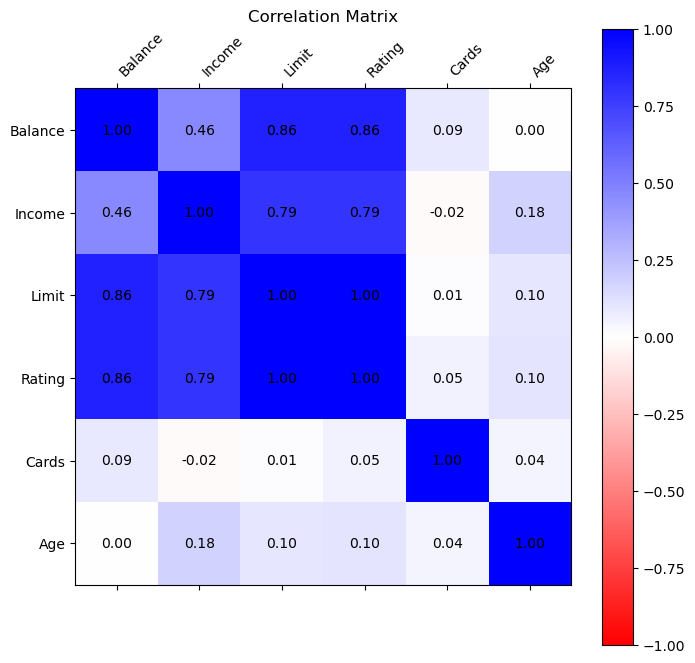

In [4]:
import matplotlib.colors as mcolors

# Create a custom diverging colormap where 0 is explicitly white
cmap = mcolors.LinearSegmentedColormap.from_list('custom_coolwarm', ['red', 'white', 'blue'], N=256)

# Create a plot to visualize the correlation matrix with white for zero
fig, ax = plt.subplots(figsize=(8, 8))

# Apply the custom colormap to the heatmap
cax = ax.matshow(corr_matrix, cmap=cmap, vmin=-1, vmax=1)

# Add color bar to the side
plt.colorbar(cax)

# Set the ticks for the x and y axis
ax.set_xticks(range(len(quantitative_vars)))
ax.set_yticks(range(len(quantitative_vars)))

# Set the labels for the ticks
ax.set_xticklabels(quantitative_vars, rotation=45, ha='left')
ax.set_yticklabels(quantitative_vars)

# Annotate the correlation matrix with the numeric values
for (i, j), val in np.ndenumerate(corr_matrix):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

# Display the plot
plt.title("Correlation Matrix")
plt.show()


### Note:

- Must filter to quantitative variables... 
- Think: how can we measure the "correlation" between categorical variables? or categorical variables vs. quantitative variables? Not straightforward always.

### Problem with identifying with correlations:
- It characterizes pairwise relationships, but does not evaluate all features' joint correlations together.
- It doesn't make sense out of the box for categorical variables. 

In [5]:
# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices #an alternative to basic pandas dfs.

y, X = dmatrices('Balance ~ Income + Limit + Rating + Cards + \
                  Age + Education + Gender + Student + Married + Ethnicity', 
                  data=credit, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

    VIF Factor                features
0    52.451853               Intercept
1     1.005849        Gender[T.Female]
2     1.031517          Student[T.Yes]
3     1.044638          Married[T.Yes]
4     1.552157      Ethnicity[T.Asian]
5     1.527504  Ethnicity[T.Caucasian]
6     2.786182                  Income
7   234.028100                   Limit
8   235.848259                  Rating
9     1.448690                   Cards
10    1.051410                     Age
11    1.019588               Education


Limit and Rating are identified as variables that are causing the multicolinearity problem. Since they are highly correlated, we can consider deleting one. Let's try to delete Limit.

In [16]:
#deleting limit improves VIFs considerably
y, X_new = dmatrices('Balance~ Income + Limit + Cards + \
                      Age + Education + Gender + Student + Married + Ethnicity', 
                      data=credit, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_new.values, i) for i in range(X_new.shape[1])]
vif["features"] = X_new.columns
print(vif)

# The intercept has a high VIF but this doesn't mean we should necessarily get rid of it. 
# If we do, we are assuming true proportionality between X and y... that's a big assumption. 
# Especially since from the summary table that it's not close to zero. 
# Btw - what are the null and alt hypotheses for that t - test? Do you remember? 

    VIF Factor                features
0    45.450166               Intercept
1     1.005827        Gender[T.Female]
2     1.022750          Student[T.Yes]
3     1.032113          Married[T.Yes]
4     1.545876      Ethnicity[T.Asian]
5     1.527414  Ethnicity[T.Caucasian]
6     2.774623                  Income
7     2.709488                   Limit
8     1.008299                   Cards
9     1.051328                     Age
10    1.013501               Education


In [14]:
# fit initial model 
model = smf.ols('Balance ~ Income + Limit + Cards + \
                Age + Education + Gender + Student + Married + Ethnicity', data=credit).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     815.7
Date:                Mon, 22 Sep 2025   Prob (F-statistic):          5.43e-254
Time:                        14:09:13   Log-Likelihood:                -2401.4
No. Observations:                 400   AIC:                             4825.
Df Residuals:                     389   BIC:                             4869.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -448.9472     33.487    -13.407      0.000    -514.785    -383.109
Gender[T.Female]         -10.5465      9.969     -1.058      0.291     -30.147       9.054
Student[T.Yes]           429.3167     16.744     25.639      0.000     396.396     462.238
Married[T.Yes]            -5.9068     10.358     -0.570      0.569     -26.272      14.458
Ethnicity[T.Asian]        14.7248     14.169      1.039      0.299     -13.133      42.583
Ethnicity[T.Caucasian]     9.8899     12.278      0.806      0.421     -14.249      34.029
Income                    -7.7682      0.235    -33.049      0.000      -8.230      -7.306
Limit                      0.2664      0.004     75.100      0.000       0.259       0.273
Cards                     23.2658      3.642      6.388      0.000      16.106      30.426
Age                       -0.6079      0.296     -2.056      0.040      -1.189      -0.027
Education                 -1.3847      1.602     -0.864      0.388      -4.535       1.765
==============================================================================
Omnibus:                       39.489   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.373
Skew:                           0.831   Prob(JB):                     3.13e-11
Kurtosis:                       3.374   Cond. No.                     3.61e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Influential points


In [8]:
#object for the analysis of influential points
infl = model.get_influence()
#members
print(dir(infl)) #these are all the things inside the infl variable
#we will only use some of this... there's a ton of extra stuff

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__firstlineno__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__static_attributes__', '__str__', '__subclasshook__', '__weakref__', '_get_drop_vari', '_ols_xnoti', '_plot_index', '_res_looo', 'aux_regression_endog', 'aux_regression_exog', 'cooks_distance', 'cov_ratio', 'det_cov_params_not_obsi', 'dfbeta', 'dfbetas', 'dffits', 'dffits_internal', 'endog', 'ess_press', 'exog', 'get_resid_studentized_external', 'hat_diag_factor', 'hat_matrix_diag', 'influence', 'k_vars', 'model_class', 'nobs', 'params_not_obsi', 'plot_index', 'plot_influence', 'resid', 'resid_press', 'resid_std', 'resid_studentized', 'resid_studentized_external', 'resid_studentized_internal', 'resid_var', 'results', 'scale', 'sigma2_not_obsi', 'summary_fr

## How to find the externally studentized residuals:

In [9]:
#externally studentized residuals
print(infl.resid_studentized_external[1:5]) #just the first 5 obs as example

[-0.11133069 -0.89373531 -0.34074765 -0.5816827 ]


## How to visualize leverage, externally studentized residuals, and Cook's distance with an "Influence Plot":

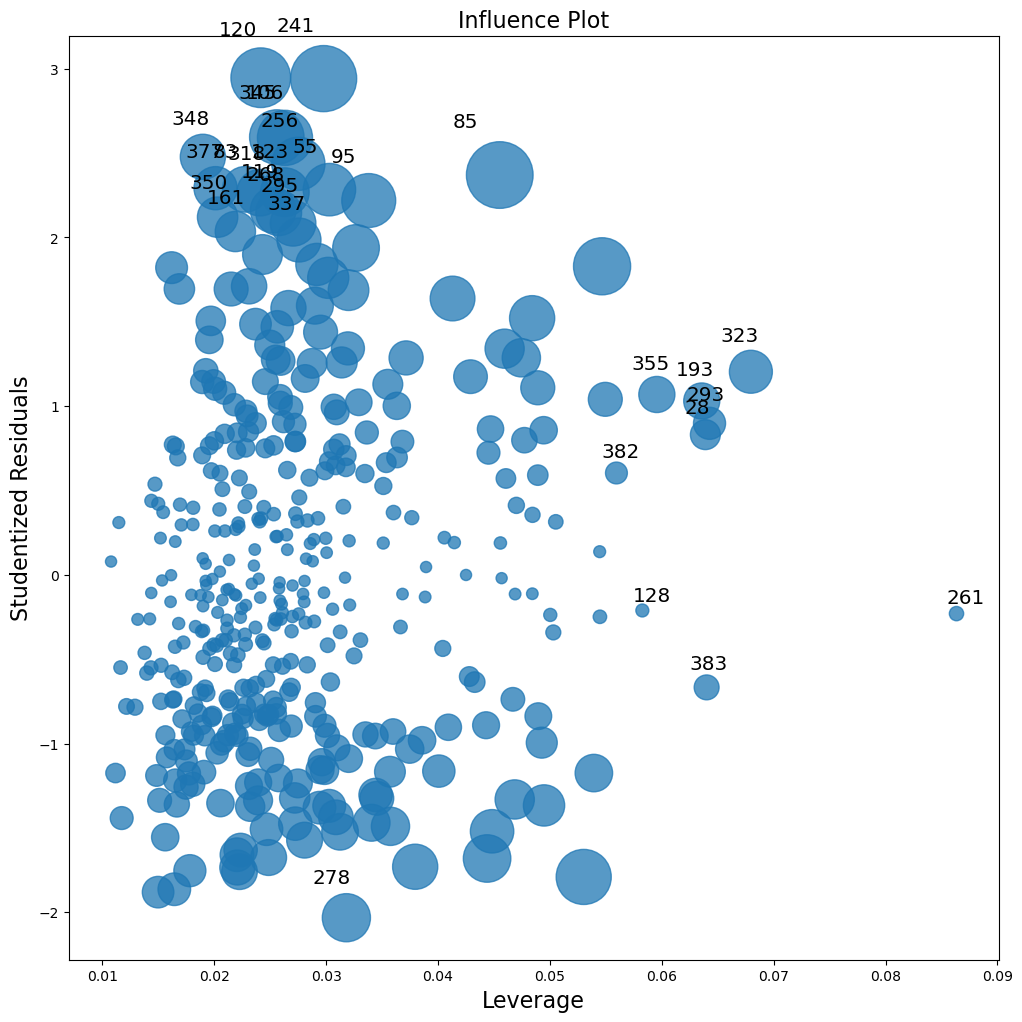

In [10]:
#graphical representation of the influence of each observation
fig, ax = plt.subplots(figsize=(12,12))
fig=sm.graphics.influence_plot(model, ax=ax, criterion="cooks") 
#size of points are given by cook's dist value
#the points with massive size whose studentized resids lie outside the range from (-3,3) should raise a "yellow" flag

In [11]:
infl.hat_diag_factor

array([0.01764134, 0.05089093, 0.03076682, 0.05296664, 0.01416333,
       0.02360276, 0.02300212, 0.03803328, 0.0202374 , 0.04980672,
       0.02518046, 0.01994282, 0.03525566, 0.02979031, 0.02251645,
       0.01923129, 0.0237608 , 0.01669913, 0.032805  , 0.03311209,
       0.0237541 , 0.0301466 , 0.02235386, 0.03105073, 0.01722399,
       0.03462004, 0.05266564, 0.02159041, 0.0682557 , 0.02012737,
       0.0318247 , 0.02592035, 0.03731889, 0.02735379, 0.02371592,
       0.03701959, 0.0152142 , 0.02688337, 0.02670128, 0.01332514,
       0.01847424, 0.05200838, 0.01656402, 0.03080144, 0.02517296,
       0.01454435, 0.04657953, 0.03736079, 0.03767719, 0.04438685,
       0.01734441, 0.03561657, 0.02035409, 0.0309683 , 0.0263008 ,
       0.03123223, 0.04897468, 0.0169301 , 0.02066816, 0.02283963,
       0.0363761 , 0.01585695, 0.03376931, 0.02275592, 0.02469887,
       0.01965897, 0.03219848, 0.02934318, 0.02243498, 0.01566833,
       0.01677596, 0.02975628, 0.02724728, 0.02155201, 0.02229

## Thresholding externally studentized residuals


In [12]:
import scipy
n=400
p=11

tstar_stud = scipy.stats.t.ppf(0.975,df=n-p-1) # t quantile at 97.5 %ile
#detection - absolute value > threshold
reg_studs=infl.resid_studentized_external
atyp_stud = np.abs(reg_studs) > tstar_stud
#which ones?
print(credit.index[atyp_stud],reg_studs[atyp_stud])

Index([ 55,  83,  85,  95, 106, 119, 120, 123, 161, 241, 256, 268, 278, 295,
       318, 337, 345, 348, 350, 377],
      dtype='int64') [ 2.28363253  2.28558871  2.37028027  2.21911588  2.59050845  2.16225126
  2.94701144  2.26873769  2.03549831  2.9417433   2.43680305  2.14677707
 -2.03173247  2.08414568  2.2657838   1.98497377  2.59557321  2.47831419
  2.12056825  2.29228244]


## Thresholding Cook's D

In [13]:
#Cook's distance
inflsum=infl.summary_frame()
reg_cook=inflsum.cooks_d

atyp_cook = np.abs(reg_cook) >= 4/n
print(credit.index[atyp_cook],reg_cook[atyp_cook])

Index([ 55,  62,  83,  85,  95,  96, 102, 106, 119, 120, 121, 123, 222, 241,
       242, 256, 268, 278, 295, 318, 320, 337, 345, 348],
      dtype='int64') 55     0.014648
62     0.011448
83     0.010944
85     0.024069
95     0.015506
96     0.017486
102    0.010466
106    0.016248
119    0.010913
120    0.019160
121    0.010675
123    0.012506
222    0.010672
241    0.023672
242    0.011871
256    0.015080
268    0.010974
278    0.012229
295    0.010881
318    0.011399
320    0.016217
337    0.010079
345    0.015846
348    0.010658
Name: cooks_d, dtype: float64


#### These observations should be looked at more carefully. Consider both including/excluding points and see if it has a large difference on your model/coefs. 
